# Importing Data and libraries

In [53]:
# Importing libraries 

import numpy as np
import pandas as pd
from sklearn.metrics import f1_score, roc_auc_score, cohen_kappa_score, precision_score, recall_score, accuracy_score, confusion_matrix
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout
from keras.models import Sequential
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.layers.normalization import BatchNormalization
from keras.models import Model, Sequential
from keras.applications.xception import Xception
from keras.applications import *
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from PIL import Image
import random
import os
#import cv2
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from xgboost import XGBClassifier 
from keras.callbacks import EarlyStopping
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm
from sklearn.decomposition import PCA



# Printing of the images

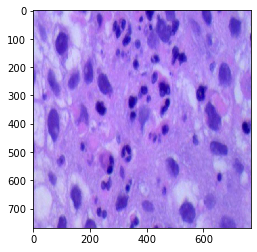

In [55]:
%matplotlib inline
for file in range(1,300):
    img1=mpimg.imread('/Users/kritika/Desktop/lung_colon_image_set/lung_image_sets/lung_aca/lungaca'+ str(file)+'.jpeg') 
    img2=mpimg.imread('/Users/kritika/Desktop/lung_colon_image_set/lung_image_sets/lung_n/lungn'+ str(file)+'.jpeg')
    img3=mpimg.imread('/Users/kritika/Desktop/lung_colon_image_set/lung_image_sets/lung_scc/lungscc'+ str(file)+'.jpeg')
    plt.imshow(img1,cmap=plt.cm.gray_r, interpolation='nearest') 
    plt.imshow(img2,cmap=plt.cm.gray_r, interpolation='nearest') 
    plt.imshow(img3,cmap=plt.cm.gray_r, interpolation='nearest') 
    #plt.show(20,20)
    

# Build the feature matrix and label vector

In [43]:
path = '/Users/kritika/Desktop/lung_colon_image_set/lung_image_sets'
lists = os.listdir(path)
labels = []
file_list = []
for folder in lists:
    files = os.listdir(path +"/"+folder)
    for file in range(0,300):
            path_file = path + "/" + folder + "/" + str(file) + '.jpeg'
            file_list.append(path_file.split(os.path.sep)[-1].replace('.jpeg', ''))
            labels.append(folder)
            dictP_n = {"path": file_list,
            "label_name": labels,
            "label": labels}   

data  = pd.DataFrame(dictP_n, index = None)
data = data.sample(frac=1)
data['label'] = data['label'].replace({"lung_aca": 1, "lung_n": 0, "lung_scc":2 })

In [45]:


data.to_csv("/Users/kritika/Desktop/lung_training.csv", index =None)
df_train = pd.read_csv("/Users/kritika/Desktop/lung_training.csv")
df_train.head()
df_train.shape


(900, 3)

In [56]:
data_dir = "/Users/kritika/Desktop/lung_colon_image_set/lung_image_sets"
SIZE_X = SIZE_Y = 128

datagen = tf.keras.preprocessing.image.ImageDataGenerator(validation_split = 0.3)

train_it = datagen.flow_from_directory(data_dir,
                                       class_mode = "categorical",
                                       target_size = (SIZE_X,SIZE_Y),
                                       color_mode="rgb",
                                       batch_size = 12, 
                                       shuffle = False,
                                       subset='training',
                                       seed = 42)

validate_it = datagen.flow_from_directory(data_dir,
                                       class_mode = "categorical",
                                       target_size = (SIZE_X, SIZE_Y),
                                       color_mode="rgb",
                                       batch_size = 12, 
                                       shuffle = False,
                                       subset='validation',
                                       seed = 42)

Found 10500 images belonging to 3 classes.
Found 4500 images belonging to 3 classes.


In [57]:
def get_features(base_model, train, validate):
    X_train = base_model.predict(train)
    y_train = train.classes

    X_val = base_model.predict(validate)
    y_val = validate.classes

    X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, test_size = 0.5, shuffle = True)
    print('Shape of X_train----->', str(X_train.shape))
    print('Shape of X_val----->', str(X_val.shape))
    print('Shape of X_test----->', str(X_test.shape))
    return (X_train, X_val, X_test, y_train, y_val, y_test)

In [58]:
def get_models():
    ANN = Sequential()
    ANN.add(Dense(128, input_dim = X_train.shape[1], activation = 'relu'))
    ANN.add(BatchNormalization())
    ANN.add(Dropout(0.2))
    ANN.add(Dense(64, activation='relu'))
    ANN.add(Dense(32, activation='relu'))
    ANN.add(Dense(16, activation='relu'))
    ANN.add(Dense(8, activation='relu'))
    ANN.add(Dense(len(train_it.class_indices), activation='softmax'))
    ANN.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    KNN = KNeighborsClassifier()
    
    SVM = SVC(kernel = 'linear')
    
    RF = RandomForestClassifier(n_estimators = 50)
    
    ADB = AdaBoostClassifier()
    
    XGB = XGBClassifier(n_estimators = 50, use_label_encoder=False)
    
    print("Defined------->")
    print("ANN -------->", "(128x64x32x16x8)")
    print("KNeighborsClassifier()")
    print("SVC(kernel = 'linear')")
    print("RandomForestClassifier(n_estimators = 50)")
    print("AdaBoostClassifier()")
    print("XGBClassifier(n_estimators = 50)")
    
    return (ANN, KNN, SVM, RF, ADB, XGB)

In [59]:
def reshape_data(X_train, X_val, X_test):
    X_train = X_train.reshape(X_train.shape[0], -1)
    X_val = X_val.reshape(X_val.shape[0], -1)
    X_test = X_test.reshape(X_test.shape[0], -1)

    print("Shape after reshaping------->")
    print("X train------->", str(X_train.shape))
    print("X val-------->", str(X_val.shape))
    print("X test-------->", str(X_test.shape))
    
    return (X_train, X_val, X_test)

In [60]:
def fit_ANN(model, X_train, y_train, X_val, y_test):
    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
    history = model.fit(X_train, y_train, validation_data=(X_val, y_test), epochs=10, verbose=1, callbacks=[es])
    return model

def fit_model(model, X_train, y_train):
    model.fit(X_train, y_train)
    return model

def get_accuracy_metrics_for_ANN(model, X_train, y_train, X_val, y_val, X_test, y_test):
    print("Train accuracy Score------------>")
    print ("{0:.3f}".format(accuracy_score(y_train, np.argmax(model.predict(X_train), axis = 1))*100), "%")
    
    print("Val accuracy Score--------->")
    val_pred = np.argmax(model.predict(X_val), axis = 1)
    print("{0:.3f}".format(accuracy_score(y_val, val_pred)*100), "%")
    
    predicted =  np.argmax(model.predict(X_test), axis = 1)
    print("Test accuracy Score--------->")
    print("{0:.3f}".format(accuracy_score(y_test, predicted)*100), "%")
    
    print("F1 Score--------------->")
    print("{0:.3f}".format(f1_score(y_test, predicted, average = 'weighted')*100), "%")
    
    print("Cohen Kappa Score------------->")
    print("{0:.3f}".format(cohen_kappa_score(y_test, predicted)*100), "%")
    
    print("Recall-------------->")
    print("{0:.3f}".format(recall_score(y_test, predicted, average = 'weighted')*100), "%")
    
    print("Precision-------------->")
    print("{0:.3f}".format(precision_score(y_test, predicted, average = 'weighted')*100), "%")
    
    cf_matrix_test = confusion_matrix(y_test, predicted)
    cf_matrix_val = confusion_matrix(y_val, val_pred)
    
    plt.figure(figsize = (12, 6))
    plt.subplot(121)
    sns.heatmap(cf_matrix_val, annot=True, cmap='Blues')
    plt.title("Val Confusion matrix")
    
    plt.subplot(122)
    sns.heatmap(cf_matrix_test, annot=True, cmap='Blues')
    plt.title("Test Confusion matrix")
    
    plt.show()

In [61]:
def fit_KNN_metrics(model, X_train, y_train, X_val, y_val, X_test, y_test):
    pca = PCA(n_components=7000)
    randlist = random.sample(range(0, X_train.shape[0]), 1000)
    if(X_train.shape[1] > 10000):
        X_train = pca.fit_transform(X_train)
        X_val = pca.transform(X_val)
        X_test = pca.transform(X_test)

    model.fit(X_train, y_train)
    get_accuracy_metrics(model, X_train[randlist, :], y_train[randlist], X_val, y_val, X_test, y_test)
    
def get_accuracy_metrics(model, X_train, y_train, X_val, y_val, X_test, y_test):
    print("Train accuracy Score------------>")
    print ("{0:.3f}".format(accuracy_score(y_train, model.predict(X_train))*100), "%")
    
    print("Val accuracy Score--------->")
    val_pred = model.predict(X_val)
    print("{0:.3f}".format(accuracy_score(y_val, val_pred)*100), "%")
    
    predicted =  model.predict(X_test)
    print("Test accuracy Score--------->")
    print("{0:.3f}".format(accuracy_score(y_test, predicted)*100), "%")
    
    print("F1 Score--------------->")
    print("{0:.3f}".format(f1_score(y_test, predicted, average = 'weighted')*100), "%")
    
    print("Cohen Kappa Score------------->")
    print("{0:.3f}".format(cohen_kappa_score(y_test, predicted)*100), "%")
    
    print("Recall-------------->")
    print("{0:.3f}".format(recall_score(y_test, predicted, average = 'weighted')*100), "%")
    
    print("Precision-------------->")
    print("{0:.3f}".format(precision_score(y_test, predicted, average = 'weighted')*100), "%")
    
    cf_matrix_test = confusion_matrix(y_test, predicted)
    cf_matrix_val = confusion_matrix(y_val, val_pred)
    
    plt.figure(figsize = (12, 6))
    plt.subplot(121)
    sns.heatmap(cf_matrix_val, annot=True, cmap='Blues')
    plt.title("Val Confusion matrix")
    
    plt.subplot(122)
    sns.heatmap(cf_matrix_test, annot=True, cmap='Blues')
    plt.title("Test Confusion matrix")
    
    plt.show()

In [62]:
base_model = ResNet50(include_top=False, input_shape=(SIZE_X, SIZE_Y, 3), weights='imagenet')

for layer in base_model.layers:
    layer.trainable = False
                   
model = Model(inputs=base_model.input, outputs=base_model.layers[-1].output)
model.summary()

94773248/94765736 [==============================] - 3s 0us/step
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 134, 134, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 64, 64, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 64, 64, 64)   256         conv1_conv[0][0]                 
_____________________________

In [63]:
X_train, X_val, X_test, y_train, y_val, y_test = get_features(model, train_it, validate_it)

Shape of X_train-----> (10500, 4, 4, 2048)
Shape of X_val-----> (2250, 4, 4, 2048)
Shape of X_test-----> (2250, 4, 4, 2048)


In [64]:
X_train, X_val, X_test = reshape_data(X_train, X_val, X_test)
ANN, KNN, SVM, RF, ADB, XGB = get_models()

ANN = fit_ANN(ANN, X_train, y_train, X_val, y_val)

Shape after reshaping------->
X train-------> (10500, 32768)
X val--------> (2250, 32768)
X test--------> (2250, 32768)
Defined------->
ANN --------> (128x64x32x16x8)
KNeighborsClassifier()
SVC(kernel = 'linear')
RandomForestClassifier(n_estimators = 50)
AdaBoostClassifier()
XGBClassifier(n_estimators = 50)
Epoch 1/10
329/329 [==============================] - 10s 31ms/step - loss: 0.1683 - accuracy: 0.9370 - val_loss: 0.1367 - val_accuracy: 0.9378
Epoch 2/10
329/329 [==============================] - 8s 25ms/step - loss: 0.0737 - accuracy: 0.9725 - val_loss: 0.0754 - val_accuracy: 0.9751
Epoch 3/10
329/329 [==============================] - 9s 27ms/step - loss: 0.0554 - accuracy: 0.9787 - val_loss: 0.0459 - val_accuracy: 0.9849
Epoch 4/10
329/329 [==============================] - 8s 25ms/step - loss: 0.0404 - accuracy: 0.9857 - val_loss: 0.0417 - val_accuracy: 0.9858
Epoch 5/10
329/329 [==============================] - 8s 25ms/step - loss: 0.0296 - accuracy: 0.9896 - val_loss: 0.042

Train accuracy Score------------>
99.181 %
Val accuracy Score--------->
96.889 %
Test accuracy Score--------->
97.822 %
F1 Score--------------->
97.822 %
Cohen Kappa Score------------->
96.734 %
Recall-------------->
97.822 %
Precision-------------->
97.913 %


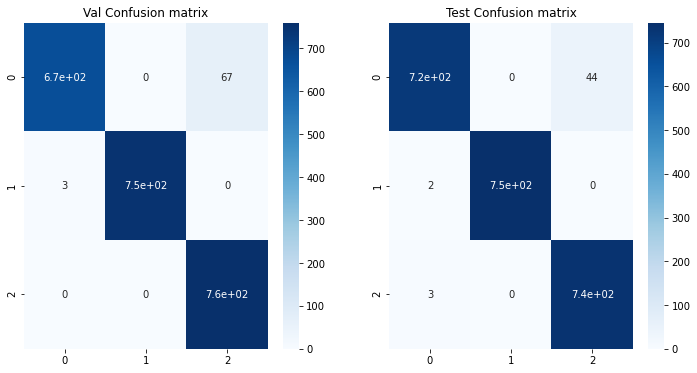

In [65]:
get_accuracy_metrics_for_ANN(ANN, X_train, y_train, X_val, y_val, X_test, y_test)

Train accuracy Score------------>
93.700 %
Val accuracy Score--------->
86.622 %
Test accuracy Score--------->
87.956 %
F1 Score--------------->
88.036 %
Cohen Kappa Score------------->
81.938 %
Recall-------------->
87.956 %
Precision-------------->
88.950 %


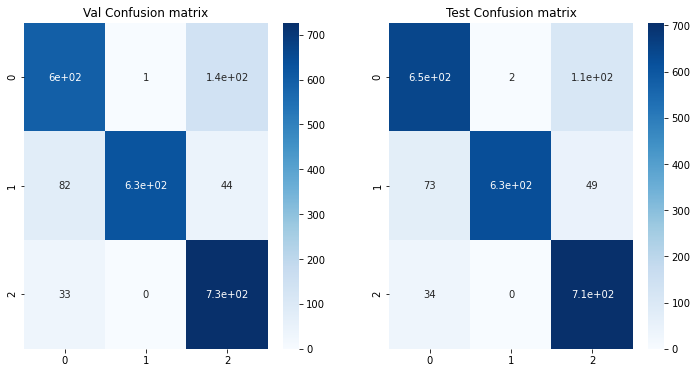

In [66]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

fit_KNN_metrics(KNN, X_train_scaled, y_train, X_val_scaled, y_val, X_test_scaled, y_test)

Train accuracy Score------------>
100.000 %
Val accuracy Score--------->
98.800 %
Test accuracy Score--------->
98.800 %
F1 Score--------------->
98.800 %
Cohen Kappa Score------------->
98.200 %
Recall-------------->
98.800 %
Precision-------------->
98.800 %


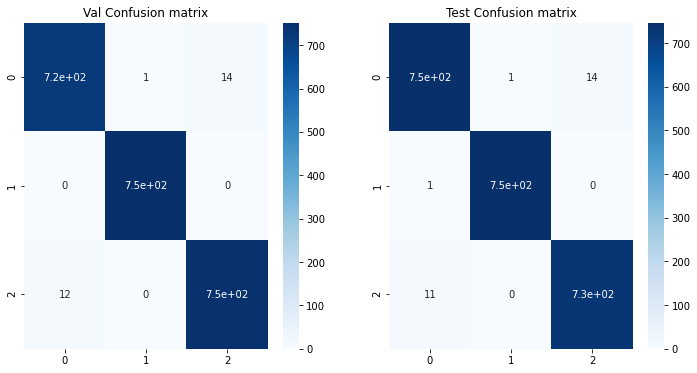

In [67]:
SVM = fit_model(SVM, X_train_scaled, y_train)
get_accuracy_metrics(SVM, X_train_scaled, y_train, X_val_scaled, y_val, X_test_scaled, y_test)

Train accuracy Score------------>
100.000 %
Val accuracy Score--------->
95.778 %
Test accuracy Score--------->
95.956 %
F1 Score--------------->
95.953 %
Cohen Kappa Score------------->
93.933 %
Recall-------------->
95.956 %
Precision-------------->
95.952 %


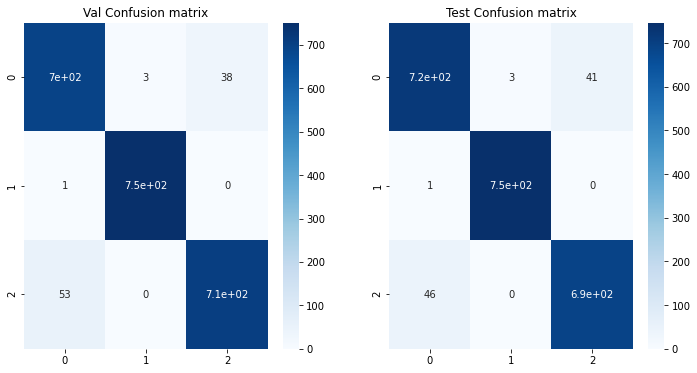

In [68]:
RF = fit_model(RF, X_train, y_train)
get_accuracy_metrics(RF,  X_train, y_train, X_val, y_val, X_test, y_test)

Train accuracy Score------------>
88.181 %
Val accuracy Score--------->
87.022 %
Test accuracy Score--------->
88.844 %
F1 Score--------------->
88.750 %
Cohen Kappa Score------------->
83.282 %
Recall-------------->
88.844 %
Precision-------------->
89.912 %


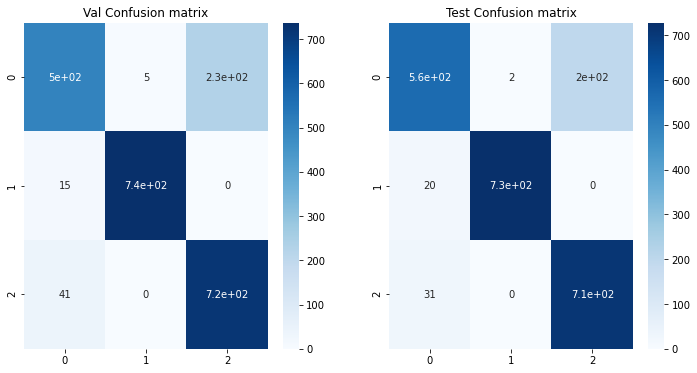

In [69]:
ADB = fit_model(ADB, X_train, y_train)
get_accuracy_metrics(ADB,  X_train, y_train, X_val, y_val, X_test, y_test)

[15:16:30] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Train accuracy Score------------>
100.000 %
Val accuracy Score--------->
97.733 %
Test accuracy Score--------->
97.644 %
F1 Score--------------->
97.643 %
Cohen Kappa Score------------->
96.466 %
Recall-------------->
97.644 %
Precision-------------->
97.642 %


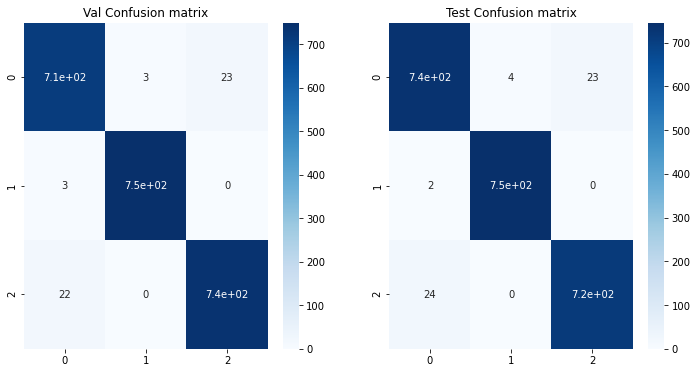

In [70]:
XGB = fit_model(XGB, X_train, y_train)
get_accuracy_metrics(XGB,  X_train, y_train, X_val, y_val, X_test, y_test)

# Ignore /////////////////////////////////////////////////

In [4]:
label=pd.read_csv('https://raw.githubusercontent.com/lkampat/Handwriting/Data/label.csv')
label.head()

,name of the file,digit label
0,0,0
1,1,1
2,2,2
3,3,3
4,4,4


In [5]:
label_vector=label["digit label"]
label_vector.head()

0    0
1    1
2    2
3    3
4    4
Name: digit label, dtype: int64

In [6]:
feature_mat=pd.DataFrame(feature_matrix)
feature_mat.head()

,0,1,2,3,4,5,6,7,8,9,...,54,55,56,57,58,59,60,61,62,63
0,0.0,2.0,88.0,217.0,158.0,21.0,0.0,0.0,16.0,0.0,...,4.0,0.0,4.0,3.0,87.0,228.0,182.0,0.0,9.0,2.0
1,0.0,0.0,11.0,187.0,210.0,78.0,5.0,0.0,13.0,5.0,...,0.0,0.0,0.0,0.0,0.0,172.0,251.0,157.0,0.0,12.0
2,0.0,0.0,5.0,59.0,240.0,199.0,2.0,0.0,5.0,0.0,...,92.0,0.0,0.0,11.0,0.0,54.0,173.0,255.0,138.0,0.0
3,6.0,0.0,108.0,255.0,213.0,13.0,10.0,0.0,2.0,131.0,...,168.0,1.0,0.0,0.0,118.0,217.0,226.0,159.0,0.0,3.0
4,0.0,6.0,0.0,34.0,160.0,7.0,7.0,0.0,5.0,0.0,...,7.0,0.0,0.0,0.0,2.0,42.0,250.0,51.0,0.0,4.0


# split the dataset into testing and training sets

In [7]:
X_train,X_test,y_train,y_test = train_test_split(feature_mat,label_vector,test_size=0.1,random_state=2)

In [8]:
y_test

154     4
564     0
1444    9
1394    1
1660    4
       ..
458     0
68      4
825     0
1153    0
1095    4
Name: digit label, Length: 180, dtype: int64

# RandomForestClassifier 

In [9]:

my_RandomForest =RandomForestClassifier(n_estimators = 19, bootstrap = True, random_state=2)
my_RandomForest.fit(X_train,y_train)
y_predict_rf= my_RandomForest.predict(X_test)
accuracy =accuracy_score(y_test,y_predict_rf)
print(accuracy)

0.9277777777777778


In [10]:
y_predict_rf

array([4, 0, 9, 1, 8, 7, 1, 5, 1, 6, 6, 7, 6, 1, 5, 5, 7, 6, 2, 7, 4, 6,
       4, 1, 5, 2, 9, 5, 4, 6, 5, 6, 3, 4, 0, 9, 9, 8, 4, 6, 8, 1, 5, 7,
       5, 4, 9, 6, 1, 7, 0, 1, 9, 7, 3, 3, 1, 1, 8, 8, 9, 8, 5, 7, 4, 7,
       2, 5, 8, 4, 3, 1, 3, 8, 7, 3, 3, 0, 8, 7, 2, 8, 5, 3, 8, 7, 6, 4,
       6, 2, 2, 0, 1, 1, 5, 3, 5, 7, 6, 8, 2, 2, 6, 4, 6, 7, 3, 7, 3, 9,
       4, 7, 0, 3, 5, 1, 5, 0, 3, 9, 2, 7, 3, 2, 0, 8, 1, 9, 2, 1, 5, 1,
       0, 3, 4, 3, 0, 7, 3, 2, 2, 7, 3, 1, 6, 7, 2, 8, 3, 1, 1, 6, 4, 8,
       2, 1, 8, 4, 1, 3, 1, 1, 9, 5, 4, 5, 7, 4, 8, 9, 5, 7, 6, 9, 4, 0,
       4, 0, 0, 4], dtype=int64)

# Misclassified data in testing set

In [11]:
y_test_new = np.asarray(y_test)
misclassified = np.where(y_test != y_predict_rf)[0]
print('\n misclassified index from y_test_new: ',misclassified,'\n')


print('\n Image name of misclassified \n')

Imagelist = []

extension = '.jpg'
for i in range(int(y_test_new.shape[0])):
    if y_predict_rf[i] != y_test_new[i]:
        print(str(y_test.index.values[i]) + extension, ": ", "predict - ",y_predict_rf[i], "/ actual - ", y_test_new[i])
        Imagelist.append(y_test_new[i])


 misclassified index from y_test_new:  [  4  16  41  44  45  49  63  66 115 130 137 165 174] 


 Image name of misclassified 

1660.jpg :  predict -  8 / actual -  4
1611.jpg :  predict -  7 / actual -  4
123.jpg :  predict -  1 / actual -  8
1582.jpg :  predict -  5 / actual -  9
492.jpg :  predict -  4 / actual -  6
1603.jpg :  predict -  7 / actual -  3
1628.jpg :  predict -  7 / actual -  4
1605.jpg :  predict -  2 / actual -  3
794.jpg :  predict -  1 / actual -  8
37.jpg :  predict -  5 / actual -  9
69.jpg :  predict -  7 / actual -  9
1468.jpg :  predict -  5 / actual -  8
1573.jpg :  predict -  4 / actual -  0


# Printing misclassified Images

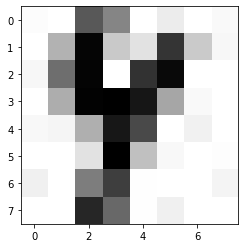

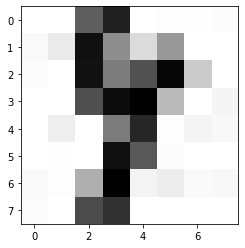

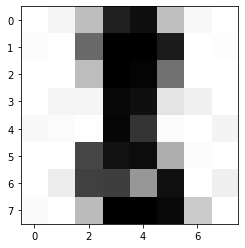

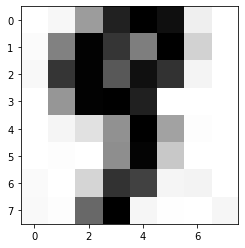

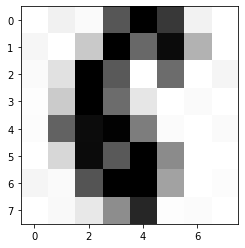

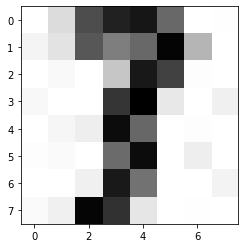

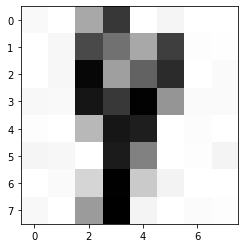

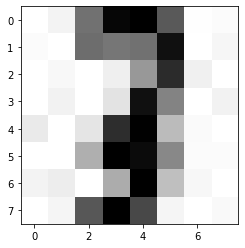

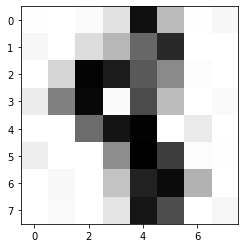

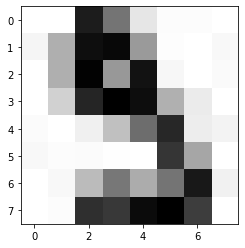

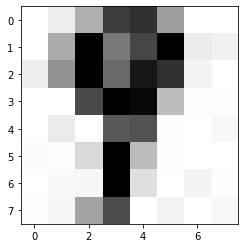

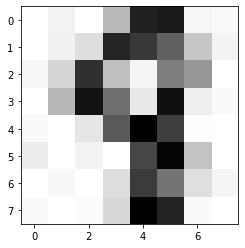

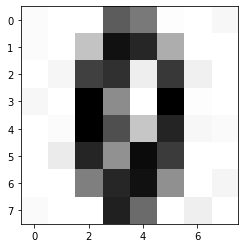

In [19]:
for x in misclassified:
    plt.figure()
    img=mpimg.imread('C:/Users/billu/OneDrive/Desktop/Digit/Digit/'+ str(y_test.index.values[x])+'.jpg') 
    plt.imshow(img,cmap=plt.cm.gray_r, interpolation='nearest') 
    